# DEEP LAYERS 2022
## Image Segmentation

**Content:**<br>
1. Data Generator<br>
2. Model Definition<br>
3. Training Procedure<br>
4. Evaluate Model on a New Data<br>

**Authors:**<br>
&copy; 2022; Filip Lux<br><br>





In [25]:
# common imports
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# custom tools
from dl_tools import ishow, show_predictions, set_dynamic_gpu_memory_allocation, train_model

# environment settings
%matplotlib tk
set_dynamic_gpu_memory_allocation()

Detected gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
import wandb

wandb.init(project="DeepLayers 2022",
           config={
           "epochs": 15,
           "batch_size": 2,
           "model_name": 'segmentation_model',
           "loss_function": "balanced_categorical_crossentropy"})

config = wandb.config

accuracy,▁▆█████████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇▆▇▇▇▇▇██████
val_loss,█▃▂▃▂▂▃▂▂▁▁▁▂▁▁
accuracy,0.99895
best_epoch,9
best_val_loss,0.00107
epoch,14
loss,0.00245
val_accuracy,0.99953


## 1. Data Generators

In [27]:
from tensorflow.keras.utils import image_dataset_from_directory

dataset_params = {"labels" : None,
                  "color_mode" : "grayscale",
                  "image_size" : (1000, 1000),
                  "batch_size" : config.batch_size,
                  "seed" : 1,
                 }

# train data generators
im_train = image_dataset_from_directory('BF-C2DL-HSC/train', **dataset_params)
gt_train = image_dataset_from_directory('BF-C2DL-HSC/train_GT', **dataset_params)

# validation data generators
im_validation = image_dataset_from_directory('BF-C2DL-HSC/validation', **dataset_params)
gt_validation = image_dataset_from_directory('BF-C2DL-HSC/validation_GT', **dataset_params)

Found 1764 files belonging to 1 classes.
Found 1764 files belonging to 1 classes.
Found 264 files belonging to 1 classes.
Found 264 files belonging to 1 classes.


In [28]:
# get one batch
for im in im_train.take(1):
    pass
for gt in gt_train.take(1):
    pass

# show shape
print(im.shape, gt.shape)

(2, 1000, 1000, 1) (2, 1000, 1000, 1)


In [36]:
import matplotlib
matplotlib.use('tkagg')

In [34]:
from dl_tools import ishow

%matplotlib tk

# show image
ishow(im[0, :, :, 0])
ishow(gt[0, :, :, 0])

In [6]:
# define preprocessing
def preprocess(img, gt):
    # preprocess both inputs
    img = preprocess_img(img)
    gt = preprocess_gt(gt)
    
    return img, gt


def preprocess_img(img):
    # input preprocessing - standardization
    img = img - tf.reduce_mean(img)
    img = img / tf.math.reduce_std(img)
    
    return img


def preprocess_gt(gt):
    # gt preprocessing - only values {0, 1}
    gt = tf.cast(gt > 128, tf.float32)
    
    return gt

In [7]:
# Augmentation
class Augment(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        # random state is updated after each call
        # both use the same seed, so they'll make the same random changes.
        self.flip_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=1)
        self.flop_inputs = tf.keras.layers.RandomFlip(mode="vertical", seed=2)
        self.flip_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=1)
        self.flop_labels = tf.keras.layers.RandomFlip(mode="vertical", seed=2)
        
        self.rotation_inputs = tf.keras.layers.RandomRotation(1,
                                                              fill_mode='reflect',
                                                              interpolation='bilinear',
                                                              seed=1)
        self.rotation_labels = tf.keras.layers.RandomRotation(1,
                                                              fill_mode='reflect',
                                                              interpolation='nearest',
                                                              seed=1)
        

    def call(self, inputs, labels):
        inputs = self.flip_inputs(inputs)
        inputs = self.flop_inputs(inputs)
        inputs = self.rotation_inputs(inputs) 
        
        labels = self.flip_labels(labels)
        labels = self.flop_labels(labels)
        labels = self.rotation_labels(labels)
        return inputs, labels

In [8]:
# training data
ds_train = tf.data.Dataset.zip((im_train, gt_train))
ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(buffer_size=5).map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()

# validation data
ds_val = tf.data.Dataset.zip((im_validation, gt_validation))
ds_val = ds_val.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# get one batch
for im, gt in ds_train.take(1):
    pass

print(im.shape, gt.shape)

(2, 1000, 1000, 1) (2, 1000, 1000, 1)


## 2. Model Definition

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def get_detection_net(input_shape=(1000, 1000, 1)):
    
    # input   
    input_layer = Input(shape=input_shape)

    # ENCODER / feature extraction
    # encoder block 1
    c1_b1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    c2_b1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1_b1)
    pool1 = MaxPooling2D((2, 2), padding='same')(c2_b1)
    
    # encoder block 2
    c1_b2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    c2_b2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1_b2)
    pool2 = MaxPooling2D((2, 2), padding='same')(c2_b2)
    
    # encoder block 3
    c1_b3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    c2_b3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c1_b3)
    
    # decoder block 2
    upsm2 = UpSampling2D((2, 2), interpolation='bilinear')(c2_b3)  
    conc2 = Concatenate(axis=3)([upsm2, c2_b2])
    c3_b2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc2)
    c4_b2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3_b2)

    # decoder block 1
    upsm1 = UpSampling2D((2, 2), interpolation='bilinear')(c4_b2)  
    conc1 = Concatenate(axis=3)([upsm1, c2_b1])
    c3_b1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc1)
    c4_b1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3_b1)

    # output
    ouput_layer = Conv2D(2, (1, 1), activation='softmax', padding='same')(c4_b1)

    return tf.keras.models.Model(inputs=input_layer, outputs=ouput_layer)

model = get_detection_net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 1000,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1000, 1000,   320         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1000, 1000,   9248        ['conv2d[0][0]']                 
                                32)                                                           

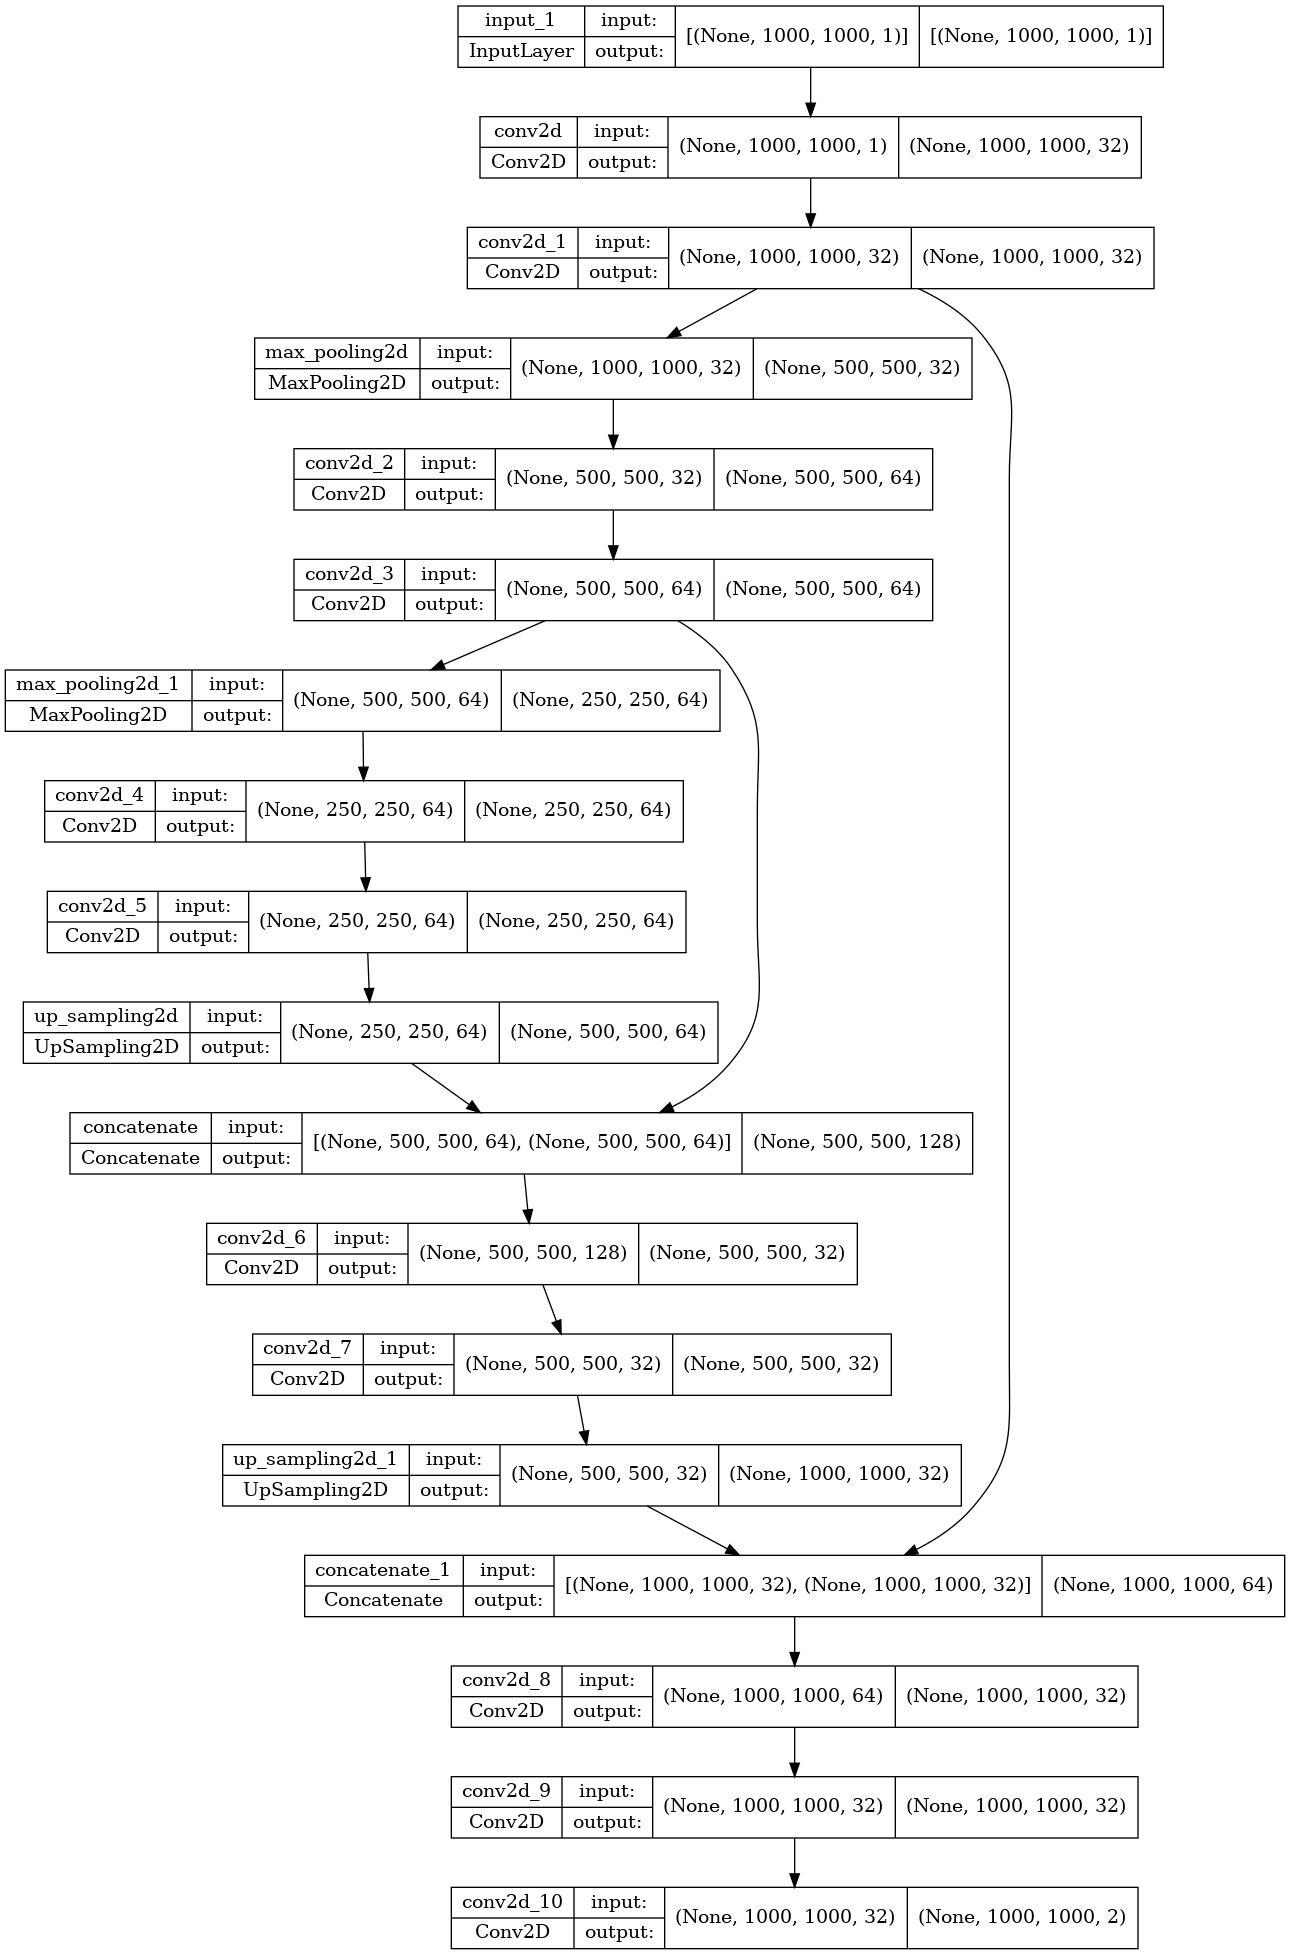

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

## 3. Training Process

In [12]:
from dl_tools import train_model

model = train_model(model, ds_train,
                  validation_data=ds_val,
                  name=config.model_name,
                  verbose=True,
                  epochs=config.epochs)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/15
150/150 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9886
Epoch 1: val_accuracy improved from -inf to 0.99776, saving model to segmentation_model
INFO:tensorflow:Assets written to: segmentation_model/assets
150/150 [==============================] - 29s 166ms/step - loss: 0.0594 - accuracy: 0.9886 - val_loss: 0.0057 - val_accuracy: 0.9978 - _timestamp: 1663325380.0000 - _runtime: 50.0000
Epoch 2/15
150/150 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9966
Epoch 2: val_accuracy improved from 0.99776 to 0.99927, saving model to segmentation_model
INFO:tensorflow:Assets written to: segmentation_model/assets
150/150 [==============================] - 25s 165ms/step - loss: 0.0078 - accuracy: 0.9966 - val_loss: 0.0026 - val_accuracy: 0.9993 - _timestamp: 1663325404.0000 - _runtime: 74.0000
Epoch 3/15
150/150 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9982
Epoch 3: val_accuracy did not improve from 

In [13]:
model = tf.keras.models.load_model(config.model_name)

## 4. Evaluate the Model on New Data

In [14]:
# test data generators
im_test = image_dataset_from_directory('BF-C2DL-HSC/test', shuffle=False, **dataset_params)
ds_test = im_test.map(preprocess_img).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 64 files belonging to 1 classes.


In [15]:
for im in ds_test.take(2):
    pass
res = model.predict(im)

In [23]:
ishow(np.squeeze(im[1]), title='Test image')
ishow(res[1, :, :, 1], title='Raw prediction')

In [24]:
from dl_tools import get_labels

labels = get_labels(res[1, :, :, 1])

ishow(labels, title='Labeled image')

In [17]:
# predict whole dataset

res = model.predict(ds_test)
res.shape

(64, 1000, 1000, 2)

In [18]:
from dl_tools import save_results

save_results(res, store_dir = 'results', img_dir = 'BF-C2DL-HSC/test')

  0%|          | 0/64 [00:00<?, ?it/s]